# Preprocessing sessions

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random
from datetime import datetime
import seaborn as sns

In [2]:
df = pd.read_csv("sessions.csv")
df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# Cleaning data
## NaN users
As we can see, there are some missing user_id. Without a *user_id*, it is impossible to link them with the file *train_user.csv*.We will delete them as we cannot do anything with them. Indeed, 

In [3]:
df.isnull().any()

user_id           True
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed      True
dtype: bool

In [4]:
df2 = df.dropna(subset=['user_id'])
removed = round(100-len(df2)/len(df)*100,2)
print(removed, '% have been removed from the original dataframe')
df2.isnull().any()

0.33 % have been removed from the original dataframe


user_id          False
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed      True
dtype: bool

## Users with invalid age from file *train_user.csv*
In the file train_user.csv, we found out that some users had an invalid age. We exported their id, so that we could remove their entries in the file *sessions.csv*

In [5]:
#Load file
df_invalid_age_user_id = pd.read_csv("invalid_age_user_id.csv")

#Rename column so that both dataframe have the same name for user_id
df_invalid_age_user_id=df_invalid_age_user_id.rename(columns = {'id':'user_id'})

print('There are ',len(df_invalid_age_user_id), 'invalid user_id')
df_invalid_age_user_id.head()

There are  2619 invalid user_id


,user_id
0,3qsa4lo7eg
1,v2x0ms9c62
2,9ouah6tc30
3,rzhouzy2ok
4,dc3udjfdij


In [6]:
#Common user_id in both dataframe
common = pd.merge(df2, df_invalid_age_user_id, how = 'right')

#Remove the user_id that are common in both dataframe (hence invalid)
df2=df2[(~df2['user_id'].isin(common['user_id']))]

removed = round(100-len(df2)/len(df)*100,2)
print('In total, ',removed, '% have been removed from the original dataframe')

In total,  0.92 % have been removed from the original dataframe


## Invalid session time
If a session time is NaN, there was probably an error during the session, and its data is unusable. Let's remove them

In [7]:
df2 = df2.dropna(subset=['secs_elapsed'])
removed = round(100-len(df2)/len(df)*100,2)
print('In total, ',removed, '% have been removed from the original dataframe')

In total,  2.19 % have been removed from the original dataframe


## Rest of NaN values
Let's check which columns have missing value, and what value these columns can have

In [8]:
df2.isnull().any()

user_id          False
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed     False
dtype: bool

In [10]:
action = df2['action'].unique()
action_type = df2['action_type'].unique()
action_detail = df2['action_detail'].unique()
print('There are', len(action), 'actions possible')
print('There are', len(action_type), 'action types possible')
print('There are', len(action_detail), 'action details possible')

action_type

There are 360 actions possible
There are 10 action types possible
There are 155 action details possible


array(['-unknown-', 'click', 'data', 'view', 'submit', 'message_post',
       'booking_request', 'partner_callback', 'booking_response', 'modify'], dtype=object)

Some action produce -unknown- for *action_type* and/or *action_detail*. Sometimes they produce NaN. We replace the NaN values with -unknown- for *action_type,action_detail, action*

In [9]:
df2.loc[df2['action'].isnull(), ['action']] = '-unknown-'
df2.loc[df2['action_type'].isnull(), 'action_type'] = '-unknown-'
df2.loc[df2['action_detail'].isnull(), 'action_detail'] = '-unknown-'

In [11]:
removed = round(100-len(df2)/len(df)*100,2)
print('In total, ',removed, '% have been removed from the original dataframe')
df2.isnull().any()

In total,  2.19 % have been removed from the original dataframe


user_id          False
action           False
action_type      False
action_detail    False
device_type      False
secs_elapsed     False
dtype: bool

# Type of devices
There are 14 devices possible. We will categorize them into 4 main categories
 - Apple product
 - Windows Product
 - Android Product
 - Others


In [12]:
device_type = df2['device_type'].unique()
print('There are', len(device_type), 'devices possible')
device_type

There are 14 devices possible


array(['Windows Desktop', '-unknown-', 'Mac Desktop', 'Android Phone',
       'iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet',
       'Linux Desktop', 'Tablet', 'Chromebook', 'Blackberry', 'iPodtouch',
       'Windows Phone', 'Opera Phone'], dtype=object)

There are 4 devices possible


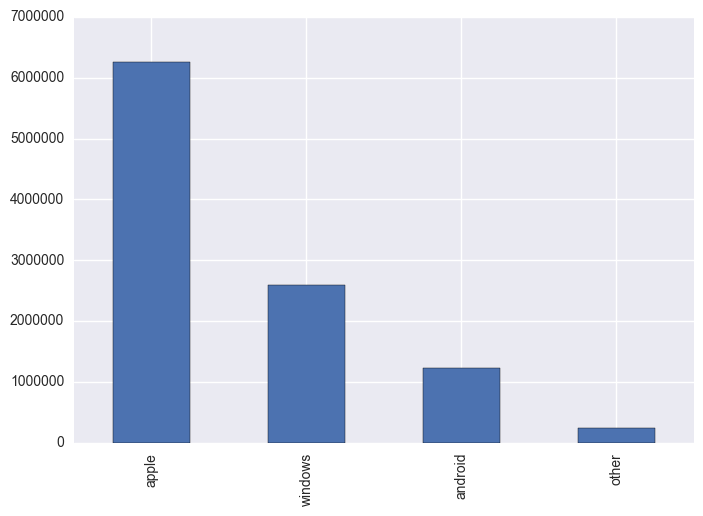

In [13]:
df2 = df2.copy()
df2.loc[df2['device_type'].str.contains('Windows') == True, 'device_type'] = 'windows'
df2.loc[df2['device_type'].str.contains('Mac|iPhone|iPad Tablet|iPodtouch' ) == True, 'device_type'] = 'apple'
df2.loc[df2['device_type'].str.contains('Android |Tablet') == True, 'device_type'] = 'android'
df2.loc[df2['device_type'].str.contains('-unknown-|Linux Desktop|Chromebook|Blackberry|Opera') == True, 'device_type'] = 'other'
device_type = df2['device_type'].unique()
print('There are', len(device_type), 'devices possible')
device_type
df2['device_type'].value_counts().plot(kind='bar')

# Actions
## Total number of actions per user

In [20]:
data_session_number = df2.groupby(['user_id'], as_index=False)['action'].sum()
num_min= 1
num_max= max(data_session_number['action'])
data_session_number.hist(bins = np.logspace(np.log10(num_min),np.log10(num_max),100))
plt.gca().set_xscale("log")
plt.title('Total number of actions per user')


TypeError: ufunc 'log10' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Time 
## Time spent on average per user

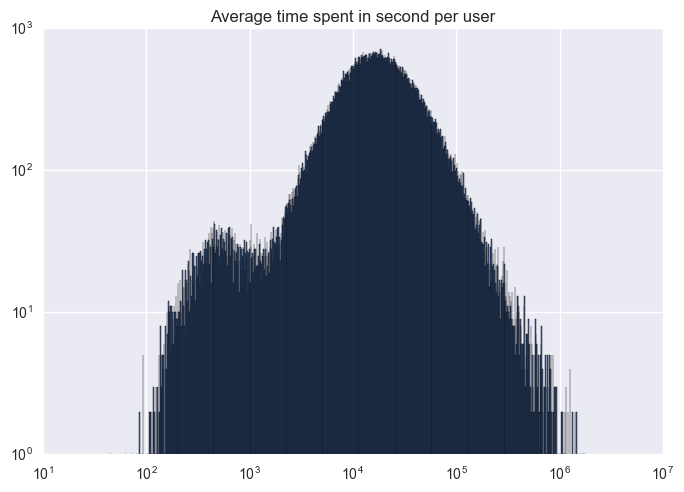

In [15]:
data_time_mean = df2.groupby(['user_id'], as_index=False).mean().groupby('user_id')['secs_elapsed'].mean()

# Showing users spending at least 10 seconds by session on average
time_min= 10
time_max= max(data_time_mean)

plt.hist(data_time_mean, bins =np.logspace(np.log10(time_min),np.log10(time_max),1000), log=True)
plt.gca().set_xscale("log")
plt.title('Average time spent in second per user')

## Time spent in total per user

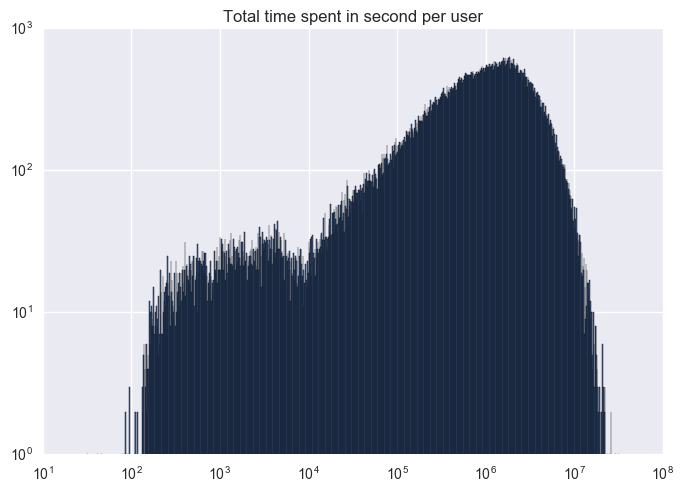

In [16]:
data_time_total = df2.groupby(['user_id'], as_index=False).sum().groupby('user_id')['secs_elapsed'].sum()

# Showing users spending at least 10 seconds by session on average
time_min= 10
time_max= max(data_time_total)

plt.hist(data_time_total, bins =np.logspace(np.log10(time_min),np.log10(time_max),1000), log=True)
plt.gca().set_xscale("log")
plt.title('Total time spent in second per user')

## Distribution of time spent 

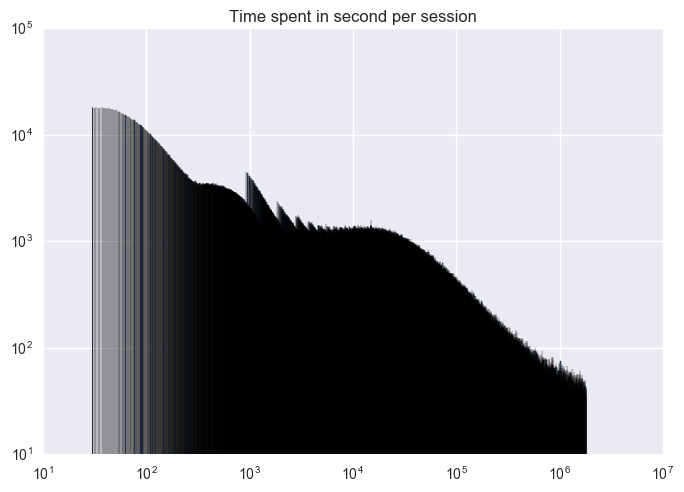

In [17]:
data_time_mean = df2['secs_elapsed']

# Showing users spending at least 30 seconds by session on average
time_min= 30
time_max= max(data_time_mean)

plt.hist(data_time_mean, bins =np.logspace(np.log10(time_min),np.log10(time_max),10000), log=True)
plt.gca().set_xscale("log")
plt.title('Time spent in second per session')